In [1]:
import re
import unicodedata
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer

# plotting style
sns.set(style='whitegrid', context='notebook', rc={"figure.figsize": (10,6)})

# config
RANDOM_STATE = 42
APPROX_BETWEENNESS = False  # set True if graph is very large (approximate betweenness)
BETWEENNESS_K = 100         # if approximate, number of samples to use


In [3]:
DATA_DIR = r"data\Spotify_Dataset_V3.csv"   # change to where you unzipped the dataset
df = pd.read_csv(DATA_DIR, delimiter= ';', low_memory=False)

## Preprocessing: Normalizing artist names and canonicalize

We normalize artist strings (strip whitespace, lower-case, remove punctuation, normalize unicode) and then map normalized names to a canonical "display" name (the most frequent original appearance). This avoids duplicate nodes caused by small formatting differences.

In [4]:
# 2. Normalize artist names and canonicalize

# Defensive check
required_cols = ['Date', 'Artists', 'Artist (Ind.)', 'id', 'Nationality', 'Points (Ind for each Artist/Nat)']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns from df: {missing}")

# Normalization helper
def normalize_artist_name(name: str) -> str:
    if pd.isna(name): 
        return ""
    # unicode normalize
    name = unicodedata.normalize("NFKD", str(name))
    # lower, strip
    name = name.lower().strip()
    # remove content inside parentheses (e.g., feat. info)
    name = re.sub(r"\(.*?\)", "", name)
    # replace common separators like &, feat., ft., x with comma to help splitting later
    # but here we only normalize the single artist name cell. Remove punctuation:
    name = re.sub(r"[^\w\s]", "", name)
    # collapse multiple spaces
    name = re.sub(r"\s+", " ", name)
    return name

# Create normalized column for Artist (Ind.)
df = df.copy()
df['artist_raw'] = df['Artist (Ind.)'].astype(str)
df['artist_norm'] = df['artist_raw'].apply(normalize_artist_name)

# Build canonical mapping: choose the most common raw spellings for each normalized name
canon_map = {}
for norm, group in df.groupby('artist_norm'):
    # choose the most frequent raw string as canonical display name
    raw_counts = group['artist_raw'].value_counts()
    canon = raw_counts.index[0]
    canon_map[norm] = canon

# Apply canonical name
df['artist_canon'] = df['artist_norm'].map(canon_map)

# Quick check: number of unique normalized vs unique raw
print("Unique raw artist entries:", df['artist_raw'].nunique())
print("Unique normalized artists:", df['artist_norm'].nunique())
print("Unique canonical artists:", df['artist_canon'].nunique())

# Optional: show examples of normalization
sample_map = list(canon_map.items())[:10]
print("\nSample normalization (norm -> canonical):")
for norm, canon in sample_map:
    print(f"'{norm}' -> '{canon}'")


Unique raw artist entries: 2208
Unique normalized artists: 2200
Unique canonical artists: 2200

Sample normalization (norm -> canonical):
'070 shake' -> '070 Shake'
'13 organise' -> '13 Organisé'
'187 strassenbande' -> '187 Strassenbande'
'2 chainz' -> '2 Chainz'
'21 savage' -> '21 Savage'
'22 savage' -> '22 Savage'
'24kgoldn' -> '24kGoldn'
'2pac' -> '2Pac'
'347aidan' -> '347aidan'
'42 dugg' -> '42 Dugg'


## Split into train/val/test

Split df by date: train = 2017–01–01 to 2021–12–31, val = 2022, test = 2023. We'll use the canonical artist names.
This is done since we will be using time related data for testing classification further ahead.

In [5]:
# 3. Train/Val/Test split
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

train_mask = (df['Date'] >= '2017-01-01') & (df['Date'] <= '2021-12-31')
val_mask = (df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')
test_mask = (df['Date'] >= '2023-01-01') & (df['Date'] <= '2023-12-31')

df_train = df[train_mask].copy()
df_val = df[val_mask].copy()
df_test = df[test_mask].copy()

print(f"Rows total: {len(df)}, train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")
print(f"Unique canonical artists in train: {df_train['artist_canon'].nunique()}")


C:\Users\racha\AppData\Local\Temp\ipykernel_38676\4025536379.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Rows total: 651936, train: 501271, val: 107876, test: 42789
Unique canonical artists in train: 1774


## Build the collaboration graph from the TRAIN data

Build an undirected weighted graph where nodes are canonical artists and an edge between two artists exists if they appear on the same song (id). Edge weight = number of co-appearances (collab count).

In [6]:
# 4. Build collaboration graph from training data
# First create mapping song_id -> canonical artist list
song_to_artists = df_train.groupby('id')['artist_canon'].agg(lambda s: list(pd.Series(s).unique())).to_dict()

G = nx.Graph()
# add all canonical artists in train as nodes
all_train_artists = sorted(df_train['artist_canon'].unique())
G.add_nodes_from(all_train_artists)

# add edges per song
for song_id, artists in song_to_artists.items():
    # only consider songs with 2+ distinct artists for collaborations
    artists = list(set([a for a in artists if a and str(a).strip() != ""]))
    if len(artists) <= 1:
        continue
    # create edges between each pair
    for i in range(len(artists)):
        for j in range(i+1, len(artists)):
            a, b = artists[i], artists[j]
            if G.has_edge(a,b):
                G[a][b]['weight'] += 1
                G[a][b]['songs'].append(song_id)
            else:
                G.add_edge(a,b, weight=1, songs=[song_id])

print(f"Graph built on train set: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
# Basic graph stats
components = nx.number_connected_components(G)
print(f"Connected components: {components}")
deg_sequence = [d for n, d in G.degree()]
print(f"Degree: min={np.min(deg_sequence)}, max={np.max(deg_sequence)}, mean={np.mean(deg_sequence):.2f}")


Graph built on train set: nodes=1774, edges=2278
Connected components: 677
Degree: min=0, max=55, mean=2.57


## Compute centrality measures and plot degree distribution

We compute:
- Degree (unweighted)
- Weighted degree (sum of edge weights)
- Betweenness centrality (exact or approximate)
- Eigenvector centrality (if graph connectivity allows)

We will plot the degree distribution and present a centrality ranking table.

In [7]:
# 5. Centrality calculations
# Degree (unweighted)
degree_dict = dict(G.degree())
# Weighted degree
degree_weighted = {n: sum(d.get('weight', 1) for _, _, d in G.edges(n, data=True)) for n in G.nodes()}

# Betweenness (exact or approximate)
if APPROX_BETWEENNESS:
    print("Computing approximate betweenness centrality...")
    betw = nx.betweenness_centrality(G, k=min(BETWEENNESS_K, max(1, int(len(G.nodes())*0.01))),
                                     seed=RANDOM_STATE, normalized=True, weight=None)
else:
    print("Computing exact betweenness centrality (may take a while for large graphs)...")
    betw = nx.betweenness_centrality(G, normalized=True, weight=None)

# Eigenvector centrality (safe-guard: if Graph is disconnected, use largest component)
try:
    if nx.is_connected(G):
        eig = nx.eigenvector_centrality(G, max_iter=500)
    else:
        # compute on largest connected component, set others to 0
        largest_cc = max(nx.connected_components(G), key=len)
        subG = G.subgraph(largest_cc)
        eig_sub = nx.eigenvector_centrality(subG, max_iter=500)
        eig = {n: (eig_sub[n] if n in eig_sub else 0.0) for n in G.nodes()}
except Exception as e:
    print("Eigenvector centrality failed:", e)
    eig = {n: 0.0 for n in G.nodes()}

# Build centrality DataFrame
centrality_df = pd.DataFrame({
    'artist': list(G.nodes()),
    'degree': [degree_dict.get(n, 0) for n in G.nodes()],
    'degree_weighted': [degree_weighted.get(n, 0) for n in G.nodes()],
    'betweenness': [betw.get(n, 0.0) for n in G.nodes()],
    'eigenvector': [eig.get(n, 0.0) for n in G.nodes()]
})
centrality_df = centrality_df.sort_values(by='degree_weighted', ascending=False)


Computing exact betweenness centrality (may take a while for large graphs)...


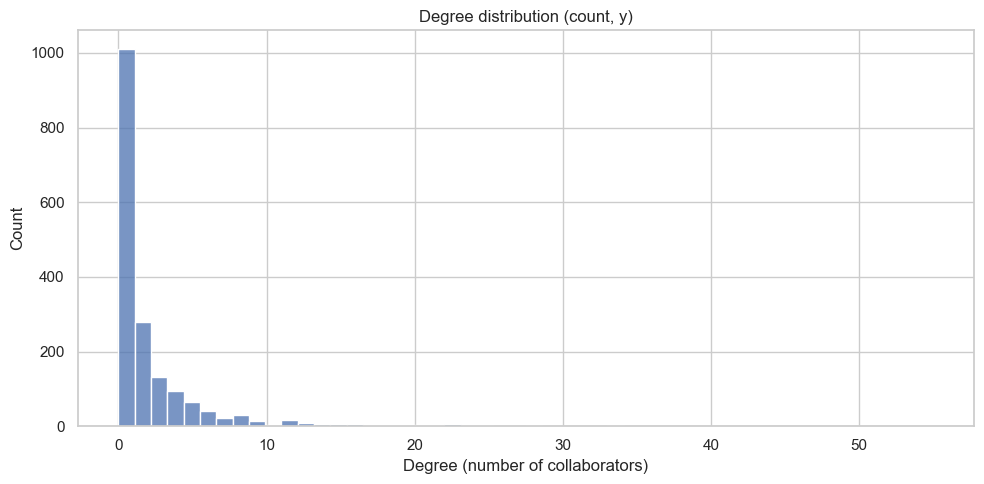

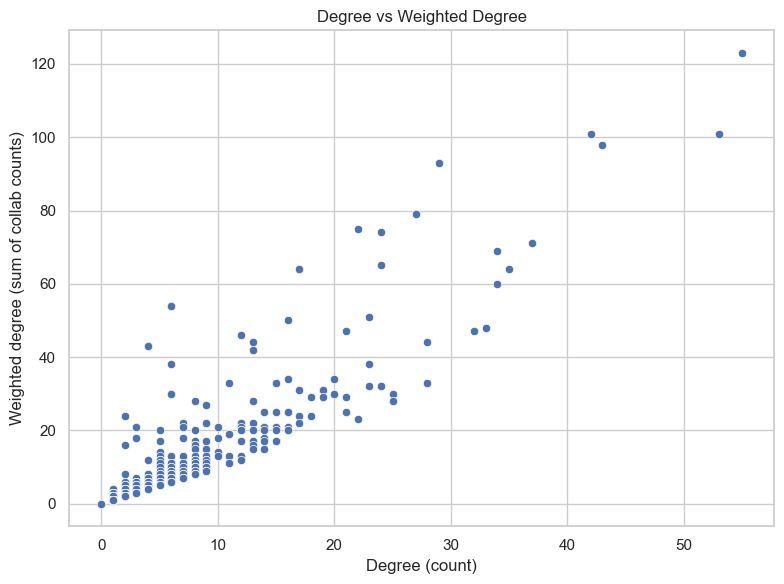

,artist,degree,degree_weighted,betweenness,eigenvector
667,J Balvin,55,123,0.052623,0.226453
144,Bad Bunny,53,101,0.015829,0.247087
98,Anuel AA,42,101,0.021537,0.244438
1222,Ozuna,43,98,0.007830,0.254466
1398,Sech,29,93,0.001349,0.216248
887,Lenny Tavárez,27,79,0.001896,0.149193
1611,Travis Scott,22,75,0.007275,0.003991
377,Dalex,24,74,0.000961,0.146757
371,Daddy Yankee,37,71,0.011004,0.193952
1181,Nicky Jam,34,69,0.004515,0.229768


In [8]:

# Plot degree distribution
plt.figure(figsize=(10,5))
sns.histplot(centrality_df['degree'], bins=50)
plt.title('Degree distribution (count, y)')
plt.xlabel('Degree (number of collaborators)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Also plot degree vs weighted degree scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=centrality_df, x='degree', y='degree_weighted')
plt.title('Degree vs Weighted Degree')
plt.xlabel('Degree (count)')
plt.ylabel('Weighted degree (sum of collab counts)')
plt.tight_layout()
plt.show()

# Display top 20 by degree_weighted
display(centrality_df.head(20))


## Assemble features: audio + network features

Create per-artist features by aggregating numeric audio features across their songs in TRAIN and joining network features. We'll include:
- Audio means: Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Valence
- Points (average per artist)
- Network features computed above.

In [9]:
# 6. Assemble per-artist features (train)
audio_cols = ['Danceability','Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Valence']
# Ensure columns exist - if naming differs, adjust accordingly
for col in audio_cols:
    if col not in df_train.columns:
        raise ValueError(f"Expected audio column '{col}' in df_train")

# Compute artist-level audio means and counts using canonical artist names
artist_audio = df_train.groupby('artist_canon')[audio_cols].mean()
artist_counts = df_train.groupby('artist_canon').size().rename('n_tracks')
artist_avg_points = df_train.groupby('artist_canon')['Points (Ind for each Artist/Nat)'].mean().rename('avg_points')

# Merge with centrality features
artist_net = centrality_df.set_index('artist')
artist_features = artist_audio.join([artist_counts, artist_avg_points, artist_net], how='left')

# Fill missing network entries (artists that have no collabs in train will have zeros)
artist_features['degree'] = artist_features['degree'].fillna(0)
artist_features['degree_weighted'] = artist_features['degree_weighted'].fillna(0)
artist_features['betweenness'] = artist_features['betweenness'].fillna(0)
artist_features['eigenvector'] = artist_features['eigenvector'].fillna(0)
artist_features['n_tracks'] = artist_features['n_tracks'].fillna(0)
artist_features['avg_points'] = artist_features['avg_points'].fillna(np.nan)

print("Artist feature matrix shape (train artists):", artist_features.shape)
artist_features.head()


Artist feature matrix shape (train artists): (1774, 13)


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,n_tracks,avg_points,degree,degree_weighted,betweenness,eigenvector
artist_canon,,,,,,,,,,,,,
$NOT,0.672000,0.717000,-7476.000000,0.226000,0.103000,0.0,0.473000,86,24.918605,1,1,0.000000,0.000000
$uicideboy$,0.792000,0.511000,-6876.000000,0.041000,0.124000,0.0,0.111000,50,68.100000,0,0,0.000000,0.000000
(G)I-DLE,0.627700,0.796433,-4443.900000,0.055883,0.013183,0.0,0.391167,60,18.550000,6,10,0.000542,0.000006
*NSYNC,0.646429,0.939857,-3971.857143,0.046571,0.102857,0.0,0.758286,21,77.476190,0,0,0.000000,0.000000
070 Shake,0.494000,0.802000,-5.080000,0.412000,0.067000,0.0,0.453000,3,37.666667,2,2,0.000000,0.000013


## Preprocess features (impute & scale)

In [10]:
# 7. Impute & scale
numeric_cols = artist_features.columns.tolist()
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(artist_features), index=artist_features.index, columns=numeric_cols)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), index=X_train_imputed.index, columns=numeric_cols)

print("Scaled training feature matrix shape:", X_train_scaled.shape)
X_train_scaled.head()


Scaled training feature matrix shape: (1774, 13)


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,n_tracks,avg_points,degree,degree_weighted,betweenness,eigenvector
artist_canon,,,,,,,,,,,,,
$NOT,-0.084039,0.355651,-0.617380,1.017886,-0.631504,-0.156426,-0.348973,-0.236514,-0.648354,-0.334124,-0.310200,-0.222825,-0.231761
$uicideboy$,0.797029,-0.909875,-0.415390,-0.779878,-0.537370,-0.156426,-2.081747,-0.279830,0.658549,-0.547185,-0.411208,-0.222825,-0.231761
(G)I-DLE,-0.409300,0.843636,0.403372,-0.635247,-1.034116,-0.156426,-0.740682,-0.267798,-0.841103,0.731181,0.598877,0.006023,-0.231490
*NSYNC,-0.271790,1.724736,0.562285,-0.725736,-0.632145,-0.156426,1.016595,-0.314724,0.942323,-0.547185,-0.411208,-0.222825,-0.231761
070 Shake,-1.390956,0.877834,1.897694,2.825368,-0.792878,-0.156426,-0.444706,-0.336382,-0.262529,-0.121063,-0.209191,-0.222825,-0.231200


We try a small range of k (e.g., 3–7) and plot inertia and silhouette to help pick k. Then we fit KMeans with the chosen k. 

K=3: inertia=16385.8, silhouette=0.2262
K=4: inertia=15209.6, silhouette=0.1242
K=5: inertia=13863.3, silhouette=0.1621
K=6: inertia=12816.0, silhouette=0.1618
K=7: inertia=11819.0, silhouette=0.1460


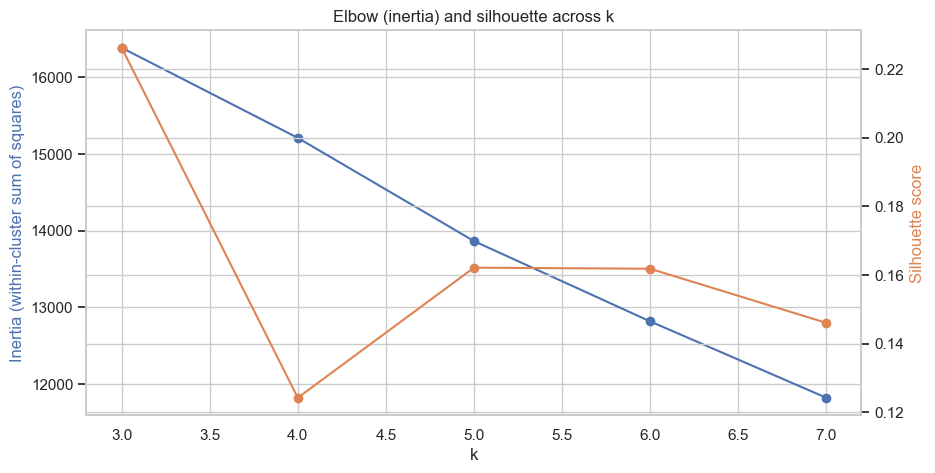

Selected best_k (by silhouette): 3
Cluster sizes (train):
0     405
1      61
2    1308
Name: count, dtype: int64


In [11]:
# 8. Try several K and visualize elbow + silhouette
ks = list(range(3,8))
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(X_train_scaled)
    inertias.append(km.inertia_)
    # silhouette requires >1 cluster, and not all labels identical
    try:
        sil = silhouette_score(X_train_scaled, labels)
    except Exception:
        sil = np.nan
    sil_scores.append(sil)
    print(f"K={k}: inertia={km.inertia_:.1f}, silhouette={sil:.4f}")

# Plot inertia (elbow) and silhouette
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(ks, inertias, '-o')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia (within-cluster sum of squares)', color='C0')
ax2 = ax1.twinx()
ax2.plot(ks, sil_scores, '-o', color='C1')
ax2.set_ylabel('Silhouette score', color='C1')
plt.title('Elbow (inertia) and silhouette across k')
plt.show()

# Choose k: prefer a k with high silhouette and reasonable inertia elbow.
# As a default, pick the k with the highest silhouette (tie-break by inertia).
best_k = ks[int(np.nanargmax(sil_scores))]
print("Selected best_k (by silhouette):", best_k)

# Fit final KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20)
train_labels = kmeans.fit_predict(X_train_scaled)
artist_features['cluster'] = train_labels

# Cluster sizes
print("Cluster sizes (train):")
print(pd.Series(train_labels).value_counts().sort_index())


## Evaluate clusters (Silhouette and Davies–Bouldin)

In [12]:
# 9. Evaluation on training set
sil_score_train = silhouette_score(X_train_scaled, train_labels)
db_score_train = davies_bouldin_score(X_train_scaled, train_labels)
print(f"Training silhouette score: {sil_score_train:.4f}")
print(f"Training Davies–Bouldin index: {db_score_train:.4f}")

# Add cluster-level summaries (centroids in original feature space)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numeric_cols)
centroids.index.name = 'cluster'
display(centroids)


Training silhouette score: 0.2262
Training Davies–Bouldin index: 1.5826


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,n_tracks,avg_points,degree,degree_weighted,betweenness,eigenvector
cluster,,,,,,,,,,,,,
0,0.584115,0.467742,-8460.395485,0.077759,0.503049,0.021699,0.423893,205.437037,59.013376,0.997531,1.214815,0.000075,0.000290
1,0.734559,0.671855,-4889.151360,0.144567,0.212597,0.003369,0.544478,2984.049180,58.226081,21.754098,41.032787,0.009035,0.078938
2,0.711819,0.717767,-4804.577436,0.133634,0.165091,0.007049,0.583751,180.460245,41.862778,2.159786,3.231651,0.000271,0.003499


## Cluster visualization (PCA 2D scatter)

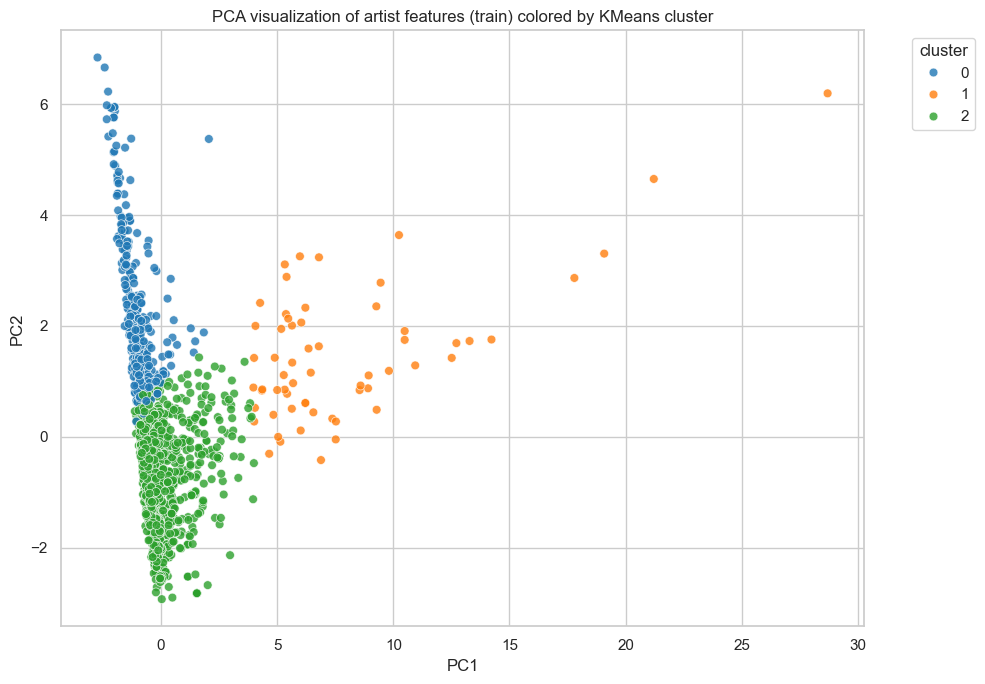

In [13]:
# 10. PCA 2D plot
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_coords = pca.fit_transform(X_train_scaled)

pca_df = pd.DataFrame(pca_coords, index=X_train_scaled.index, columns=['PC1','PC2'])
pca_df['cluster'] = train_labels

plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.8)
plt.title('PCA visualization of artist features (train) colored by KMeans cluster')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Centrality ranking table (top artists per cluster)

In [14]:
# 11. Centrality ranking per cluster
artist_features_reset = artist_features.reset_index().rename(columns={'index':'artist'})
for c in sorted(artist_features_reset['cluster'].unique()):
    sub = artist_features_reset[artist_features_reset['cluster']==c]
    print(f"\nCluster {c} - size {len(sub)}")
    top_deg = sub.sort_values('degree_weighted', ascending=False).head(8)[['artist_canon','degree','degree_weighted','betweenness','n_tracks']]
    print(" Top by weighted-degree:")
    display(top_deg)
    top_bet = sub.sort_values('betweenness', ascending=False).head(8)[['artist_canon','degree','degree_weighted','betweenness','n_tracks']]
    print(" Top by betweenness:")
    display(top_bet)



Cluster 0 - size 405
 Top by weighted-degree:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
881,Lauv,5,14,0.001132,2066
1003,Madison Beer,6,11,0.003239,297
1042,Martin Garrix,7,11,0.002339,1692
156,Bass Santa,6,9,0.000002,3
60,Alessia Cara,4,8,0.001175,941
725,Jhayco,4,7,0.000000,441
183,Bing Crosby,4,7,0.000003,238
1039,Maroon 5,6,7,0.002521,2890


 Top by betweenness:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
1388,Sandro Cavazza,2,3,0.003239,174
1003,Madison Beer,6,11,0.003239,297
1039,Maroon 5,6,7,0.002521,2890
1042,Martin Garrix,7,11,0.002339,1692
831,Kid Cudi,4,4,0.001820,300
686,James Arthur,3,3,0.001625,2284
1720,ZAYN,4,4,0.001193,1185
60,Alessia Cara,4,8,0.001175,941



Cluster 1 - size 61
 Top by weighted-degree:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
667,J Balvin,55,123,0.052623,10166
98,Anuel AA,42,101,0.021537,5208
144,Bad Bunny,53,101,0.015829,9527
1222,Ozuna,43,98,0.007830,7045
1398,Sech,29,93,0.001349,3167
887,Lenny Tavárez,27,79,0.001896,1868
1611,Travis Scott,22,75,0.007275,5930
377,Dalex,24,74,0.000961,1511


 Top by betweenness:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
667,J Balvin,55,123,0.052623,10166
553,Future,16,50,0.028441,2158
92,Anitta,24,32,0.022924,1012
1634,Ufo361,13,17,0.022662,99
399,David Guetta,32,47,0.021596,2227
98,Anuel AA,42,101,0.021537,5208
16,6ix9ine,17,31,0.017413,1215
1618,Trippie Redd,28,33,0.016165,503



Cluster 2 - size 1308
 Top by weighted-degree:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
1013,Maite Perroni,6,54,0.000000,41
66,Alfonso Herrera,6,54,0.000000,9
1291,RBD,6,54,0.000000,9
307,Christian Chávez,6,54,0.000000,9
81,Anahí,6,54,0.000000,9
312,Christopher von Uckermann,6,54,0.000000,9
454,Dulce María,6,54,0.000000,9
8,21 Savage,12,46,0.000972,1518


 Top by betweenness:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
945,Luciano,11,13,0.008413,61
1672,Wesley Safadão,3,3,0.007994,107
1219,Os Barões Da Pisadinha,5,6,0.006964,225
1252,Pharrell Williams,14,17,0.006168,271
89,Angèle,2,2,0.006113,55
911,Lil Wayne,11,11,0.006050,496
1363,SCH,11,19,0.006039,77
702,Jax Jones,10,14,0.005796,805


## Assigning meaningful cluster names

In [15]:
artist_features_reset.columns

Index(['artist_canon', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Valence', 'n_tracks', 'avg_points',
       'degree', 'degree_weighted', 'betweenness', 'eigenvector', 'cluster'],
      dtype='object')

In [16]:
# Compute cluster means
features = ['n_tracks', 'degree', 'degree_weighted', 'betweenness', 'eigenvector', 'avg_points']
cluster_summary = artist_features_reset.groupby('cluster')[features].mean().reset_index()

# Heuristic labeling function
def interpret_cluster(row):
    if row['degree'] > 10:
        return "Hub Artist"
    elif row['degree'] <= 2:
        return "Isolated/Solo Artist"
    elif row['betweenness'] > 0.02 and row['degree_weighted'] > 3:
        return "Bridge Artist"
    elif row['degree_weighted'] <= 2 and row['degree'] > 3:
        return "Niche Collaborator"
    else:
        return "Emerging Networker"

cluster_summary['Cluster Label'] = cluster_summary.apply(interpret_cluster, axis=1)


In [17]:

# Merge labels back to artist_df
label_map = cluster_summary.set_index('cluster')['Cluster Label'].to_dict()
artist_features_reset['cluster_label'] = artist_features_reset['cluster'].map(label_map)

display(cluster_summary)


,cluster,n_tracks,degree,degree_weighted,betweenness,eigenvector,avg_points,Cluster Label
0,0,205.437037,0.997531,1.214815,0.000075,0.000290,59.013376,Isolated/Solo Artist
1,1,2984.049180,21.754098,41.032787,0.009035,0.078938,58.226081,Hub Artist
2,2,180.460245,2.159786,3.231651,0.000271,0.003499,41.862778,Emerging Networker


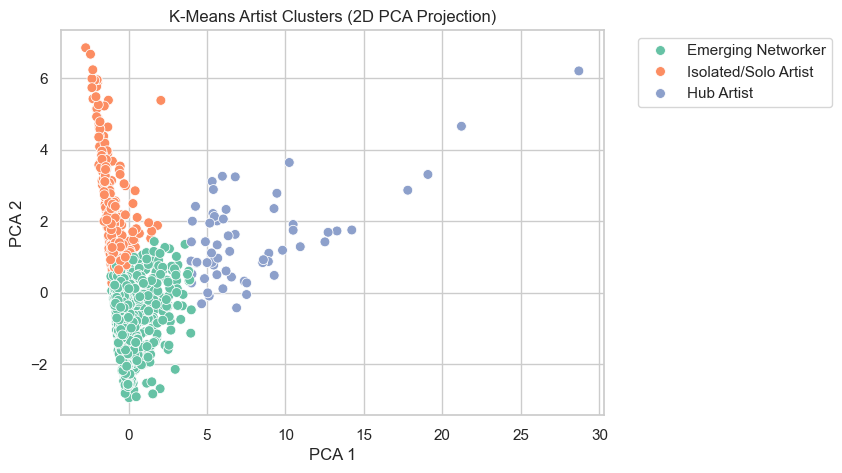

In [18]:
from sklearn.decomposition import PCA
artist_df = artist_features_reset.copy()
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_train_scaled)
artist_df['pca1'] = reduced[:, 0]
artist_df['pca2'] = reduced[:, 1]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=artist_df, x='pca1', y='pca2', hue='cluster_label', palette='Set2', s=50)
plt.title("K-Means Artist Clusters (2D PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Saving the outputs

In [19]:
# 14. Save outputs for later use
out_dir = "./collab_clustering_outputs"
import os, joblib
os.makedirs(out_dir, exist_ok=True)

# Save dataframes
artist_df.reset_index().rename(columns={'index':'artist'}).to_csv(os.path.join(out_dir, 'artist_features_train_with_clusters.csv'), index=False)

# Save models / preprocessors
joblib.dump(imputer, os.path.join(out_dir, 'imputer.joblib'))
joblib.dump(scaler, os.path.join(out_dir, 'scaler.joblib'))
joblib.dump(kmeans, os.path.join(out_dir, f'kmeans_k{best_k}.joblib'))

print("Saved outputs to", out_dir)


Saved outputs to ./collab_clustering_outputs
